# Prediction of experimental band gap

This notebooks applies MODNet on the matbench experimental band gap data. It is a good example on how MODNet can be used for a composition only task.

## Dependencies

In [1]:
import numpy as np
from matminer.datasets import load_dataset
from modnet.models import MODNetModel
from modnet.preprocessing import MODData
import matplotlib.pyplot as plt 
from pymatgen.core import Composition

2024-01-21 17:30:48.168214: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-21 17:30:48.218996: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-21 17:30:48.219055: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-21 17:30:48.220618: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-21 17:30:48.228330: I tensorflow/core/platform/cpu_feature_guar

## Dataset import:
The matbench_expt_gap dataset contains measured band gaps for 4604 compositions of inorganic semiconductors from Zhuo et al., JPCL.

In [2]:
from matminer.datasets import load_dataset

df = load_dataset("matbench_expt_gap")
df["composition"] = df["composition"].map(Composition) # maps composition to a pymatgen composition object
df.head()

,composition,gap expt
0,"(Ag, Au, S)",0.00
1,"(Ag, W, Br)",0.00
2,"(Ag, Ge, Pb, S)",1.83
3,"(Ag, Ge, Pb, Se)",1.51
4,"(Ag, B, Br)",0.00


In [3]:
df.describe()

,gap expt
count,4604.000000
mean,0.975951
std,1.445034
min,0.000000
25%,0.000000
50%,0.000000
75%,1.812500
max,11.700000


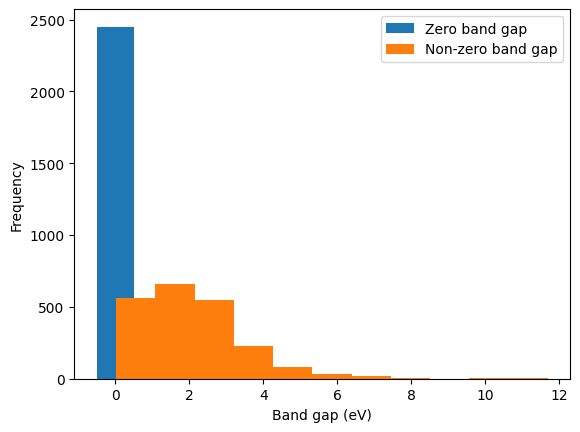

In [4]:
fig, ax = plt.subplots(facecolor="w")
ax.hist(df.where(df["gap expt"] == 0)["gap expt"], bins=1, density=False, label="Zero band gap")
ax.hist(df.where(df["gap expt"] > 0)["gap expt"], bins=11, density=False, label="Non-zero band gap")
ax.set_ylabel("Frequency")
ax.set_xlabel("Band gap (eV)")
ax.legend()

## MODData

In [5]:
# This instantiates the MODData
data = MODData(
    materials=df["composition"], # you can provide composition objects to MODData
    targets=df["gap expt"], 
    target_names=["gap_expt_eV"]
)

2024-01-21 17:31:33,801 - modnet - INFO - Loaded CompositionOnlyMatminer2023Featurizer featurizer.


In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
# Featurization of the moddata
# It will automatically apply composition only featurizers
data.featurize(n_jobs=8)

2024-01-21 17:32:06,422 - modnet - INFO - Computing features, this can take time...
2024-01-21 17:32:06,424 - modnet - INFO - Applying composition featurizers...
2024-01-21 17:32:06,431 - modnet - INFO - Applying featurizers (AtomicOrbitals(), AtomicPackingEfficiency(), BandCenter(), ElementFraction(), ElementProperty(data_source=<matminer.utils.data.MagpieData object at 0x7fa6121fe790>,
                features=['Number', 'MendeleevNumber', 'AtomicWeight',
                          'MeltingT', 'Column', 'Row', 'CovalentRadius',
                          'Electronegativity', 'NsValence', 'NpValence',
                          'NdValence', 'NfValence', 'NValence', 'NsUnfilled',
                          'NpUnfilled', 'NdUnfilled', 'NfUnfilled', 'NUnfilled',
                          'GSvolume_pa', 'GSbandgap', 'GSmagmom',
                          'SpaceGroupNumber'],
                stats=['minimum', 'maximum', 'range', 'mean', 'avg_dev',
                       'mode']), IonProperty(),

MultipleFeaturizer: 100%|██████████| 4604/4604 [30:15<00:00,  2.54it/s]


2024-01-21 18:02:38,002 - modnet - INFO - Data has successfully been featurized!


In [8]:
data.save('out/matbench_expt_gap_nofeatureselection.moddata')

2024-01-21 18:02:38,027 - modnet - INFO - Data successfully saved as out/matbench_expt_gap_nofeatureselection.moddata!


### train-test split

In [9]:
from sklearn.model_selection import train_test_split
split = train_test_split(range(100), test_size=0.1, random_state=1234)
train, test = data.split(split)

In [10]:
# train.feature_selection(n=-1)
# if you want to use precomputed cross_nmi of the MP. This saves time :
data.feature_selection(n=-1, use_precomputed_cross_nmi=True)

2024-01-21 18:02:38,048 - modnet - INFO - Loading cross NMI from 'Features_cross' file.
2024-01-21 18:02:38,079 - modnet - WARNING - Feature mismatch between precomputed `Features_cross` and `df_featurized`. Missing columns: {'Miedema|Miedema_deltaH_amor', 'Miedema|Miedema_deltaH_ss_min'}
2024-01-21 18:02:38,082 - modnet - INFO - Starting target 1/1: gap_expt_eV ...
2024-01-21 18:02:38,083 - modnet - INFO - Computing mutual information between features and target...
2024-01-21 18:02:44,721 - modnet - INFO - Computing optimal features...
2024-01-21 18:02:47,405 - modnet - INFO - Selected 50/242 features...
2024-01-21 18:02:49,535 - modnet - INFO - Selected 100/242 features...
2024-01-21 18:02:51,053 - modnet - INFO - Selected 150/242 features...
2024-01-21 18:02:51,955 - modnet - INFO - Selected 200/242 features...
2024-01-21 18:02:52,224 - modnet - INFO - Done with target 1/1: gap_expt_eV.
2024-01-21 18:02:52,225 - modnet - INFO - Merging all features...
2024-01-21 18:02:52,225 - modne

## MODNet model

In [11]:
model = MODNetModel([[['gap_expt_eV']]],
                    weights={'gap_expt_eV':1},
                    num_neurons = [[256], [128], [16], [16]],
                    n_feat = 150,
                    act =  "elu"
                   )

2024-01-21 18:02:52.262332: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-21 18:02:52.295009: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### training

In [10]:
model.fit(train,
          val_fraction = 0.1,
          lr = 0.0002,
          batch_size = 64,
          loss = 'mae',
          epochs = 100,
          verbose = 1,
         )

Epoch 1/100
2/2 [==============================] - 0s 53ms/step - loss: 1.1403 - mae: 1.1403 - val_loss: 1.1806 - val_mae: 1.1806
Epoch 2/100
2/2 [==============================] - 0s 7ms/step - loss: 0.9577 - mae: 0.9577 - val_loss: 0.8098 - val_mae: 0.8098
Epoch 3/100
2/2 [==============================] - 0s 7ms/step - loss: 0.8267 - mae: 0.8267 - val_loss: 0.5956 - val_mae: 0.5956
Epoch 4/100
2/2 [==============================] - 0s 8ms/step - loss: 0.7825 - mae: 0.7825 - val_loss: 0.5075 - val_mae: 0.5075
Epoch 5/100
2/2 [==============================] - 0s 7ms/step - loss: 0.7321 - mae: 0.7321 - val_loss: 0.4663 - val_mae: 0.4663
Epoch 6/100
2/2 [==============================] - 0s 8ms/step - loss: 0.6460 - mae: 0.6460 - val_loss: 0.4526 - val_mae: 0.4526
Epoch 7/100
2/2 [==============================] - 0s 7ms/step - loss: 0.6106 - mae: 0.6106 - val_loss: 0.4397 - val_mae: 0.4397
Epoch 8/100
2/2 [==============================] - 0s 7ms/step - loss: 0.6307 - mae: 0.6307 - va

2/2 [==============================] - 0s 8ms/step - loss: 0.3096 - mae: 0.3096 - val_loss: 0.2566 - val_mae: 0.2566
Epoch 65/100
2/2 [==============================] - 0s 8ms/step - loss: 0.3074 - mae: 0.3074 - val_loss: 0.2392 - val_mae: 0.2392
Epoch 66/100
2/2 [==============================] - 0s 8ms/step - loss: 0.3029 - mae: 0.3029 - val_loss: 0.2391 - val_mae: 0.2391
Epoch 67/100
2/2 [==============================] - 0s 8ms/step - loss: 0.2964 - mae: 0.2964 - val_loss: 0.2274 - val_mae: 0.2274
Epoch 68/100
2/2 [==============================] - 0s 8ms/step - loss: 0.2932 - mae: 0.2932 - val_loss: 0.2589 - val_mae: 0.2589
Epoch 69/100
2/2 [==============================] - 0s 7ms/step - loss: 0.3011 - mae: 0.3011 - val_loss: 0.2981 - val_mae: 0.2981
Epoch 70/100
2/2 [==============================] - 0s 8ms/step - loss: 0.2972 - mae: 0.2972 - val_loss: 0.2714 - val_mae: 0.2714
Epoch 71/100
2/2 [==============================] - 0s 8ms/step - loss: 0.2911 - mae: 0.2911 - val_loss

### Predicting

In [14]:
pred = model.predict(test)
pred.head()
# 

TypeError: 'NoneType' object is not subscriptable

In [11]:
pred = model.predict(test)
pred.head()

,gap_expt_eV
id40,-0.508559
id35,2.871215
id81,-0.570688
id61,1.950733
id98,2.004308


In [ ]:
mae_test = np.absolute(pred.values-test.df_targets.values).mean()
print(f'mae: {mae_test}')
# 

In [12]:
mae_test = np.absolute(pred.values-test.df_targets.values).mean()
print(f'mae: {mae_test}')

mae: 0.3859002037048341
